# Historical ice thickness

This notebook plots ICESat-2 sea ice thickness vs. Pan-Arctic Ice Ocean Modeling and Assimilation System [(PIOMAS)](http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/) sea ice thickness. PIOMAS is a project out of the Polar Science Center at the University of Washington that models historical sea ice thickness and volume. Plotting ICESat-2 and PIOMAS sea ice thickness allows for a comparison of model predictions and satellite observations. 
 
**Input**:
 - xarray dataset from the jupyter book's google bucket
 
 
 **Output**: 
  - Plots of sea ice thickness 

```{tip}
Try running this notebook in Google Colab! Toggle over the rocketship icon at the top of the page and click Colab to open a new window and run the notebook. <br><br>To run a single cell, type **Shift+Enter**. To run the whole notebook, under **Runtime** click **Run all**. Note that you will have to run the notebook from the very beginning and load all the Google Colab dependencies for the code to work.
```

In [1]:
#this cell will load dependencies for running the notebook in Google Colab
#this cell may take a while to run
import sys

#if code is running in google colab, run these cells to install neccessary libraries
if 'google.colab' in sys.modules: 
    !pip install netcdf4
    !pip install xarray==0.16.0

## Import notebook dependencies

In [2]:
import os
import numpy as np
import xarray as xr
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from textwrap import wrap

#remove warnings to improve display
import warnings
warnings.filterwarnings('ignore')
 
#increase resolution for notebook outputs
%config InlineBackend.figure_format = 'retina'

## Load data into notebook
Copy file from the book's google bucket and load into an xarray dataset. 

### Load ICESat-2 dataset

In [3]:
!gsutil -m cp gs://is2-pso-seaice/icesat2-book-data.nc ./
IS2dataset = xr.open_dataset('icesat2-book-data.nc')

Copying gs://is2-pso-seaice/icesat2-book-data.nc...
/ [1/1 files][157.1 MiB/157.1 MiB] 100% Done                                    
Operation completed over 1 objects/157.1 MiB.                                    


### Load PIOMAS dataset

In [4]:
!gsutil -m cp gs://is2-pso-seaice/piomas-regridded-data.nc ./
PIOdataset = xr.open_dataset('piomas-regridded-data.nc')

Copying gs://is2-pso-seaice/piomas-regridded-data.nc...
/ [1/1 files][266.7 MiB/266.7 MiB] 100% Done  15.1 MiB/s ETA 00:00:00           
Operation completed over 1 objects/266.7 MiB.                                    


## Restrict datasets to region of interest

In [5]:
#function from regional_analysis notebook
def restrictRegionally(dataset, regionKeyList): 
    """Restrict dataset to input regions.
    
    Args: 
        dataset (xr Dataset): dataset generated by Load_IS2 notebook
        regionKeyList (list): list of region keys to restrict data to 
        
    Returns: 
        regionalDataset (xr Dataset): dataset with restricted data to input regions
    """
    
    def checkKeys(regionKeyList, regionTbl): 
        """Check that regionKeyList was defined correctly

        Raises: 
            ValueError if regionKeyList was not defined correctly 
            warning if all data was removed from the dataset
        """
        if type(regionKeyList) != list: #raise a ValueError if regionKeyList is not a list 
            raise ValueError('regionKeyList needs to be a list. \nFor example, if you want to restrict data to the Beaufort Sea, define regionKeyList = [13]')

        for key in regionKeyList: 
            if key not in list(regionTbl['key']): 
                raise ValueError('Region key ' + str(key) + ' does not exist in region mask. \n Redefine regionKeyList with key numbers from table')

        if len(regionKeyList) == 0: 
            warnings.warn('You removed all the data from the dataset. Are you sure you wanted to do this? \n If not, make sure the list regionKeyList is not empty and try again. \n If you intended to keep data from all regions, set regionKeyList = list(tbl[\"key\"])')
 
    #create a table of keys and labels
    regionMask = dataset.region_mask.attrs
    regionTbl = pd.DataFrame({'key': regionMask['keys'], 'label': regionMask['labels']})
    
    #call function to check if regionKeyList was defined correctly
    checkKeys(regionKeyList, regionTbl)
    
    #keys to remove (all keys that are note listed in regionKeyList)
    keysToRemove = [key for key in list(regionTbl['key']) if key not in regionKeyList]
    
    #filter elements from the ice thickness DataArray where the region is the desired region
    regionalDataset = dataset.copy()
    for var in dataset.data_vars: 
        if var != 'seaice_conc_monthly_cdr':
            regionalVar = regionalDataset[var]
            for key in keysToRemove: 
                regionalVar = regionalVar.where(regionalVar['region_mask'] != key)
            regionalDataset[var] = regionalVar
    
    #find name of labels 
    labels = [regionTbl[regionTbl['key'] == key]['label'].item() for key in regionKeyList]
    
    #add new attributes describing changes made to the dataset
    if len(labels) < len(regionTbl['key']): 
        if set(regionKeyList) == set([10,11,12,13,15]): #convert to sets so unordered lists are compared
            regionalDataset.attrs['regions with data'] = 'Inner Arctic'
        else:    
            regionalDataset.attrs['regions with data'] = ('%s' % ', '.join(map(str, labels)))
        print('Regions selected: ' + regionalDataset.attrs['regions with data'])
    else: 
        regionalDataset.attrs['regions with data'] = 'All'
        print('Regions selected: All \nNo regions will be removed')
    
    return regionalDataset

In [6]:
myKeys = [10,11,12,13,15] #Inner Arctic
IS2dataset = restrictRegionally(IS2dataset, regionKeyList = myKeys)
PIOdataset = restrictRegionally(PIOdataset, regionKeyList = myKeys)

Regions selected: Inner Arctic
Regions selected: Inner Arctic


## Calculate ICESat-2 means

In [7]:
#calculate mean monthly ICESat-2 sea ice thickness 
IS2means = IS2dataset['ice_thickness_filled'].mean(dim = ['x','y'], skipna = True)
IS2means.attrs['long_name'] = 'ICESat-2 mean ice thickness'

#calculate mean monthly ICESat-2 sea ice thickness uncertainty
IS2uncs = IS2dataset['ice_thickness_unc_filled'].mean(dim = ['x','y'], skipna = True)
IS2uncs.attrs['long_name'] = 'ICESat-2 mean uncertainty'

### Compile into one dataset

In [8]:
IS2 = xr.Dataset(data_vars = {'mean_ice_thickness': IS2means, 'mean_ice_thickness_unc': IS2uncs})
IS2.attrs = IS2dataset.attrs

## Calculate PIOMAS means

### Mean sea ice thickness

In [9]:
PIOmeans = PIOdataset['PIOMAS_ice_thickness'].mean(dim = ['x','y'], skipna = True)
PIOmeans.attrs['long_name'] = 'PIOMAS mean ice thickness'

### Mean detrended uncertainty

#### Define functions used in calculation 

In [10]:
def get_varDT(Years, Thickness):
    """ Detrend linear time series  
    """
    trendT, interceptT, r_valsT, probT, stderrT = scipy.stats.linregress(Years, Thickness)
    lineT = (trendT * Years) + interceptT
    ThicknessDT = Thickness - lineT
    return ThicknessDT, lineT

In [11]:
def is_mon(xarray_val, desired_mon):
    """ Check if current month is desired month 
    """
    xarray_mon = pd.to_datetime(xarray_val).month
    if xarray_mon == desired_mon:
        return xarray_val
    else: 
        return None

#### Call functions to perform uncertainty calculation

In [12]:
#loop through months in a year and calculate uncertainty for each month 
standDevDT, standDev, monDates, thicknessDT, slopes = [],[],[],[],[]
months = np.arange(1, 12 + 1, 1)  #integers corresponding to months of the year

for mon in months:
    #get dates for each month (i.e. for January get 1978-01, 1979-01, 1980-01, etc)
    times_by_mon = [is_mon(val, mon) for val in PIOmeans.time.values if (is_mon(val, mon) != None)]
    monDates.append(times_by_mon)
    
    #get array with year-mon converted to integer value
    time_integers = np.arange(0, len(times_by_mon))
    
    #get detrended uncertainty and append to list
    thickness_detrended, regLine = get_varDT(time_integers, PIOmeans.sel(time = times_by_mon).values)
    thicknessDT.append(thickness_detrended)
    standDevDT.append(np.std(thickness_detrended))
    slopes.append(regLine)
    
    #get trended uncertainty and append to list 
    standDev.append(np.std(PIOmeans.sel(time = times_by_mon).values))
    
#get a list as long as PIOmeans of all the monthly natural variabilities
standDevCyclic = []
for date in PIOmeans.time.values:
    standDevCyclic.append(standDevDT[pd.to_datetime(date).month - 1])
    
#create DataArray with corresponding uncertainties
PIOuncs = xr.DataArray(standDevCyclic, dims = 'time', coords = {'time': PIOmeans.time.values}, attrs = {'long_name':'PIOMAS mean detrended uncertainty'})

### Compile into one dataset 

In [13]:
PIO = xr.Dataset(data_vars = {'mean_ice_thickness': PIOmeans, 'mean_ice_thickness_unc': PIOuncs})
PIO.attrs = PIOdataset.attrs

## Winter comparison: PIOMAS vs. ICESat-2
Here we will plot PIOMAS and ICESat-2 mean monthly ice thickness on the same axes to visualize differences in the two datasets over winter 2018-2019 and winter 2019-2020. 

### Define plotting function 

In [18]:
def plotMeans(PIO, IS2, title = None, figPath = None):
    """Plot ICESat-2 ice thickness and PIOMAS ice thickness on the same axis
    
    Args: 
        PIO (xr Dataset): dataset with PIOMAS mean ice thickness and mean ice thickness detrended uncertainty
        IS2 (xr Dataset): dataset with ICESat-2 mean ice thickness and mean ice thickness uncertainty
        title (str, optional): string description of plot (default to None)
        figPath (str, optional): path to save fig (default to None)

    Returns: 
        Figure displayed in notebook 
        
    Notes: 
        Uncertainties commented out of function
    """
    
    #initialize figure and axes
    fig = plt.figure(figsize = [8,5]) 
    ax = plt.axes()
    gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines 

    #plot PIOMAS data 
    PIO['mean_ice_thickness'].plot(ax = ax, color = 'purple', marker = 'o', label = PIO['mean_ice_thickness'].attrs['long_name'])
    #ax.fill_between(PIO.time.values, PIO['mean_ice_thickness'] + PIO['mean_ice_thickness_unc'], PIO['mean_ice_thickness'] - PIO['mean_ice_thickness_unc'], facecolor = 'purple', alpha = 0.1, edgecolor = 'none', label = PIO['mean_ice_thickness_unc'].attrs['long_name'])

    #plot ICESat-2 data
    IS2['mean_ice_thickness'].plot(color = 'dodgerblue', marker = 's', linestyle = '-.', label = IS2['mean_ice_thickness'].attrs['long_name'])
    #ax.fill_between(IS2.time.values, IS2['mean_ice_thickness'] + IS2['mean_ice_thickness_unc'], IS2['mean_ice_thickness'] - IS2['mean_ice_thickness_unc'], facecolor = 'dodgerblue', alpha = 0.1, edgecolor = 'none', label = IS2['mean_ice_thickness_unc'].attrs['long_name'])

    #display plot with descriptive legend, ylabel, and title
    plt.legend()
    plt.ylabel('Mean sea ice thickness (m)')
    plt.title(PIO.attrs['regions with data'] + ': mean monthly sea ice thickness')
    
    #save figure
    if figPath != None:
        plt.savefig(figPath, bbox_inches='tight', dpi = 250)
    
    plt.show()

### Plot comparison for winter 18-19

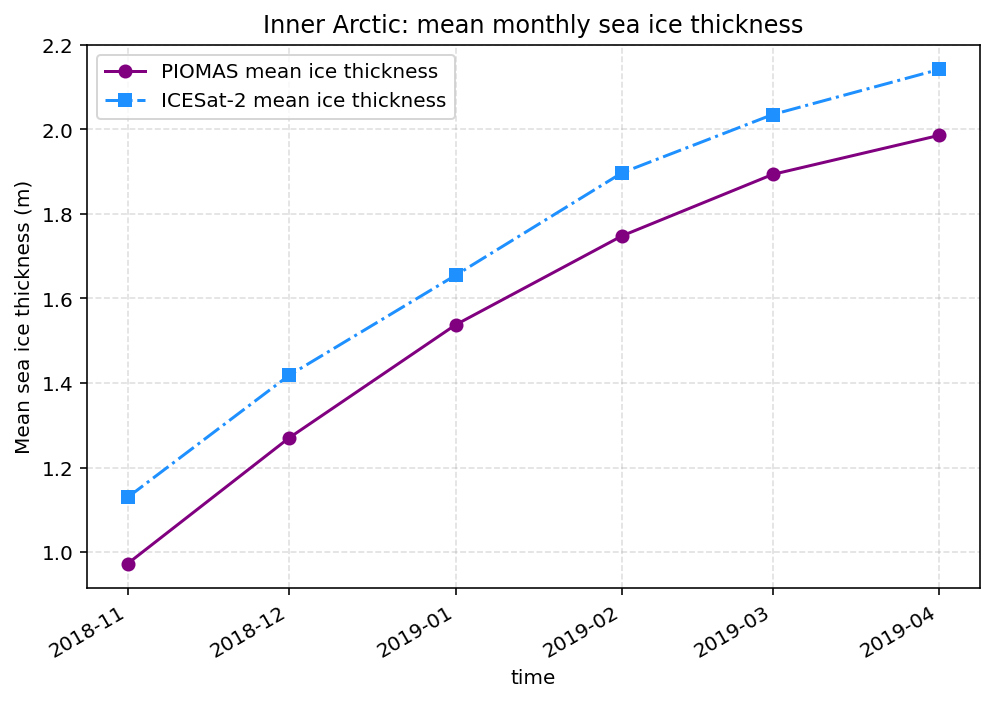

In [20]:
plotMeans(PIO = PIO.sel(time = slice('Nov 2018','Apr 2019')), IS2 = IS2.sel(time = slice('Nov 2018','Apr 2019')))

### Plot comparison for winter 19-20

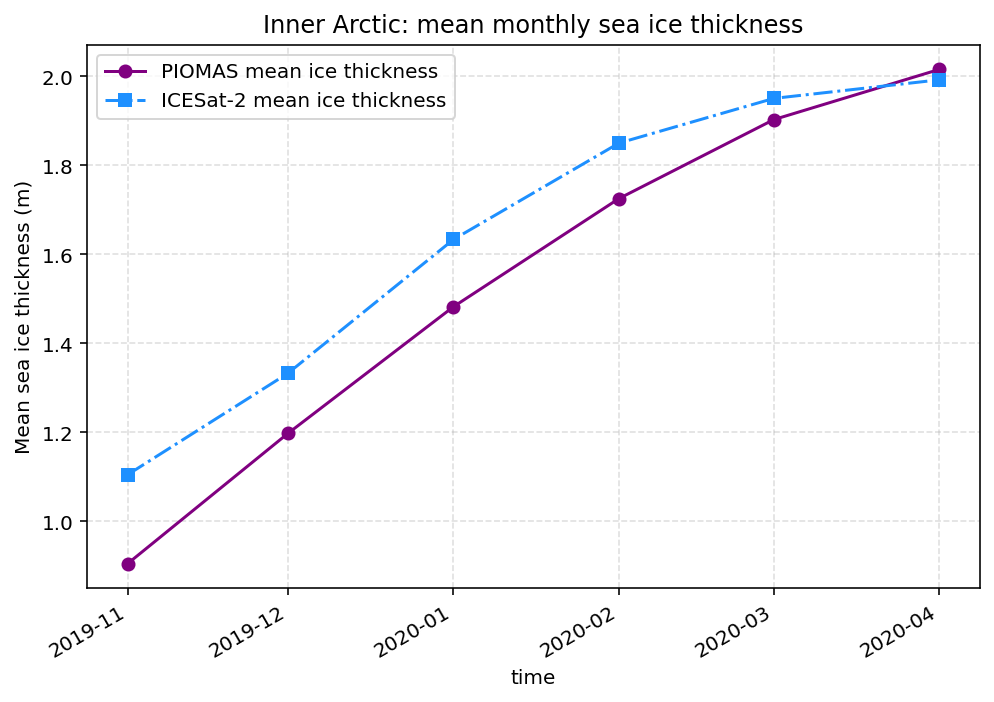

In [16]:
plotMeans(PIO = PIO.sel(time = slice('Nov 2019','Apr 2020')), IS2 = IS2.sel(time = slice('Nov 2019','Apr 2020')))

## Plot PIOMAS with overlayed ICESat-2 data
From the PIOMAS reanalysis data, this plot shows the yearly melting and growing of sea ice as well as the long term decreasing trend in mean ice thickness. ICESat-2 data is overlayed on the PIOMAS plot, along with a rolling 12 month mean. 

In [ ]:
#initialize figure and axes 
fig = plt.figure(figsize = [8,5]) 
ax = plt.axes()
gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines 

#plot data 
PIO['mean_ice_thickness'].plot(ax = ax, color = 'steelblue', label = PIO['mean_ice_thickness'].attrs['long_name'])
IS2['mean_ice_thickness'].plot(ax = ax, color = 'magenta', label = IS2['mean_ice_thickness'].attrs['long_name'])

#using pandas rolling mean function, add a rolling mean 
rollingMeanInterval = 12 #number of months over which to take mean
tbl = pd.DataFrame({'means': PIO['mean_ice_thickness'].values})
rollingMean = np.array(tbl.rolling(rollingMeanInterval).mean()['means'])
ax.plot(PIO.time.values, rollingMean, c = 'darkblue', label = 'PIOMAS ' + str(rollingMeanInterval) + ' month mean')

#display plot with descriptive legend, ylabel, and title
plt.legend()
plt.ylabel('Mean sea ice thickness (m)')
plt.title(PIO.attrs['regions with data'] + ': mean monthly sea ice thickness')
plt.show()

## Understanding detrended uncertainty 
Detrended uncertainty captures natural variability in mean ice thickness, while ignoring the downward trend of ice thickness due to climate change. The regression line is subtracted from the mean ice thickness resulting in detrended ice thickness, which can be used to solve for natural variability (detrended uncertainty) in ice thickness.<br><br>The figure below shows these values for a single month over the period of 1978-2020 to illustrate this concept. 

### Choose month of interest

In [ ]:
month = 7 #July

### Visualize trended & detrended thickness 

In [ ]:
#initialize figure & axes
fig = plt.figure(figsize = [8,5]) 
ax = plt.axes()
gridlines = plt.grid(b = True, linestyle = '--', alpha = 0.4) #add gridlines 
years = np.arange(1978, 1978 + len(thicknessDT[month - 1]), 1)
plt.title(PIO.attrs['regions with data'] + ': ' + pd.to_datetime(monDates[month - 1])[0].strftime('%B') + ' ice thickness & uncertainty', fontsize = 14)

#plot thickness 
monthlyThickness = PIO.sel(time = monDates[month - 1]).mean_ice_thickness.values
ax.plot(years, monthlyThickness, color = 'blue', label = 'mean ice thickness')

#plot regression line
ax.plot(years, slopes[month - 1], color = 'magenta', linestyle = '-.', label = 'regression line')

#plot detrended thickness 
ax.plot(years, thicknessDT[month - 1], color = 'maroon', label = 'mean detrended ice thickness')

#add text describing variability 
explanation = "\n".join(wrap('Observing the difference in spread of the two plots, one can note that natural variability from the detrended mean sea ice thickness is ' + str(round(standDevDT[month - 1],2)) + ' meters, while mean monthly variability (including the decreasing trend in ice thickness due to climate change) is ' + str(round(standDev[month - 1],2)) + ' meters.', 40))
ax.text(x = 1.075, y = 0.73, s = explanation, horizontalalignment = 'left', verticalalignment = 'top', fontsize = 11.5, transform = ax.transAxes, bbox = {'facecolor':'none', 'edgecolor':'lightgrey', 'boxstyle':'round'})

#add legends & show plot
plt.legend(bbox_to_anchor=(1.56, 1), fontsize = 11.5)
plt.show()